# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: NVIDIA GeForce GTX 1650 with Max-Q Design


In [2]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [4]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [5]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [6]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

In [7]:
iterator = iter(preparer.dataloaders)
batch = next(iterator)
batch[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [8]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [512, 1024],
                 out_channels = 128,
                 kernel_size = 3)

In [9]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.0064594850351568315
Epoch [2/100], Loss: 0.0027162267517996954
Epoch [3/100], Loss: 0.0019250976998591795
Epoch [4/100], Loss: 0.0013595393221476114
Epoch [5/100], Loss: 0.0009999201295431703
Epoch [6/100], Loss: 0.0006706118186411914
Epoch [7/100], Loss: 0.0004237965465290472
Epoch [8/100], Loss: 0.00025584812537999825
Epoch [9/100], Loss: 0.0001722101659834152
Epoch [10/100], Loss: 0.00013866607183445013
Epoch [11/100], Loss: 0.00010542458578129299
Epoch [12/100], Loss: 9.071439419130911e-05
Epoch [13/100], Loss: 8.158535438269609e-05
Epoch [14/100], Loss: 7.607034622196807e-05
Epoch [15/100], Loss: 6.956194029044127e-05
Epoch [16/100], Loss: 6.466538614404272e-05
Epoch [17/100], Loss: 6.840206173365004e-05
Epoch [18/100], Loss: 6.969468018724002e-05
Epoch [19/100], Loss: 6.508559839858207e-05
Epoch [20/100], Loss: 0.0001868418986487086
Epoch [21/100], Loss: 0.00036571590899256987
Epoch [22/100], Loss: 8.966395706011098e-05
Epoch [23/100], Loss: 4.8011005155785

## CerberusTS Training (No Foresight)

In [10]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 128, 128],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 kernel_size = 3)
                 

In [11]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.00046416319921263496
Epoch [2/100], Loss: 0.0003574553415819537
Epoch [3/100], Loss: 0.00033158698810439093
Epoch [4/100], Loss: 0.0003094235360913444
Epoch [5/100], Loss: 0.000288077462464571
Epoch [6/100], Loss: 0.0002693069674569415
Epoch [7/100], Loss: 0.0002528663801786024
Epoch [8/100], Loss: 0.0002398035378428176
Epoch [9/100], Loss: 0.00023347286201897077
Epoch [10/100], Loss: 0.0002162900666007772
Epoch [11/100], Loss: 0.00021235628133581486
Epoch [12/100], Loss: 0.00020186990332149435
Epoch [13/100], Loss: 0.0001956354019785067
Epoch [14/100], Loss: 0.00018484766776964535
Epoch [15/100], Loss: 0.00017337745084660127
Epoch [16/100], Loss: 0.00017150954907265258
Epoch [17/100], Loss: 0.00016509857512573946
Epoch [18/100], Loss: 0.00015974864567397162
Epoch [19/100], Loss: 0.0001514506728562992
Epoch [20/100], Loss: 0.0001431394165410893
Epoch [21/100], Loss: 0.00014051588077563794
Epoch [22/100], Loss: 0.0001373581033112714
Epoch [23/100], Loss: 0.0001342

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [12]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [2048, 1024, 512, 256],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 kernel_size = 3)

In [13]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.00045926876009616535
Epoch [2/100], Loss: 0.00029323047703655903
Epoch [3/100], Loss: 0.00022414021455915644
Epoch [4/100], Loss: 0.0001717231700604316
Epoch [5/100], Loss: 0.00014561811502062483
Epoch [6/100], Loss: 0.00012154396554251435
Epoch [7/100], Loss: 0.00010710274182201829
Epoch [8/100], Loss: 9.401732804690255e-05
Epoch [9/100], Loss: 8.454156724837958e-05
Epoch [10/100], Loss: 7.415958350975415e-05
Epoch [11/100], Loss: 6.878311369291623e-05
Epoch [12/100], Loss: 6.147329257146339e-05
Epoch [13/100], Loss: 5.8124192528339335e-05
Epoch [14/100], Loss: 5.421418347395956e-05
Epoch [15/100], Loss: 4.9810063264885686e-05
Epoch [16/100], Loss: 4.517174741522467e-05
Epoch [17/100], Loss: 4.561272787213966e-05
Epoch [18/100], Loss: 4.299874335629283e-05
Epoch [19/100], Loss: 3.848682371426548e-05
Epoch [20/100], Loss: 3.757742623747618e-05
Epoch [21/100], Loss: 3.462616119577433e-05
Epoch [22/100], Loss: 3.3233679650948034e-05
Epoch [23/100], Loss: 3.24972124

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

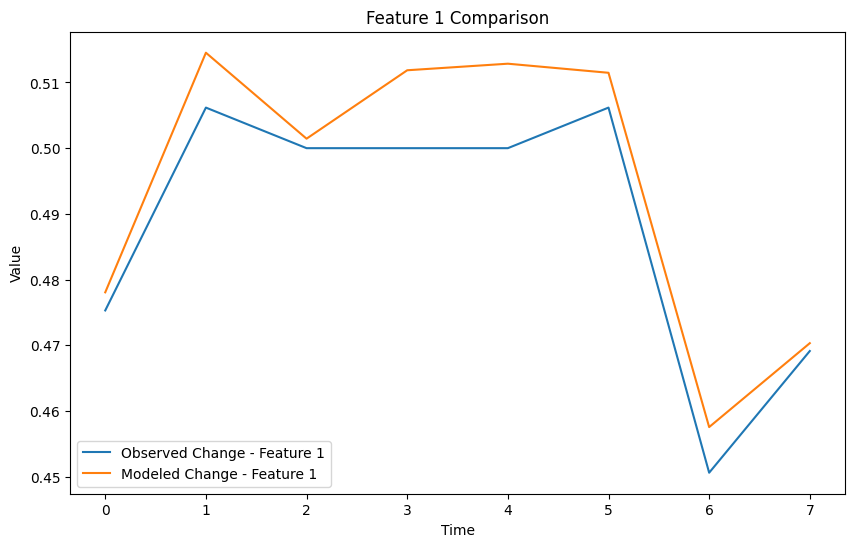

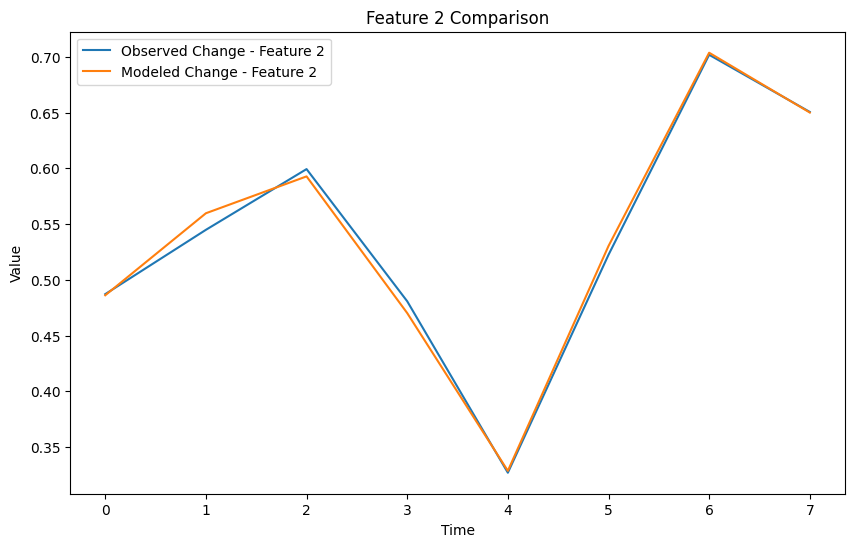

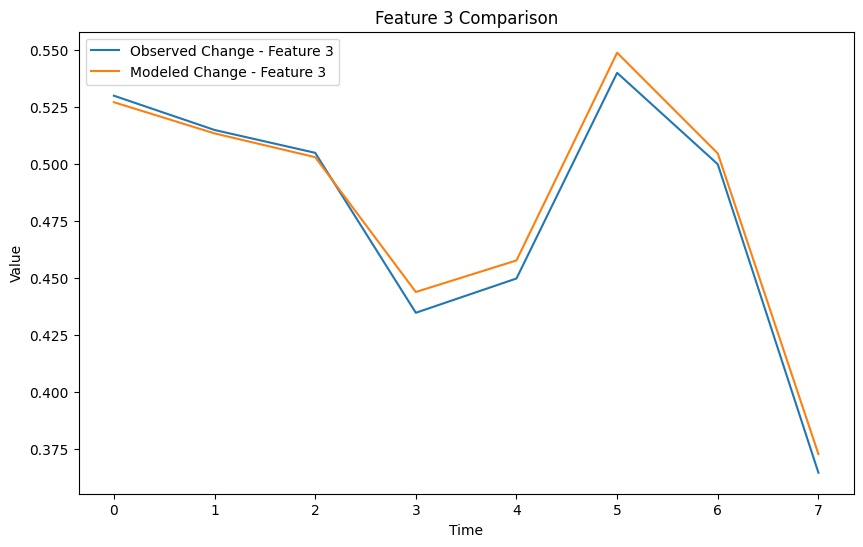

In [24]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

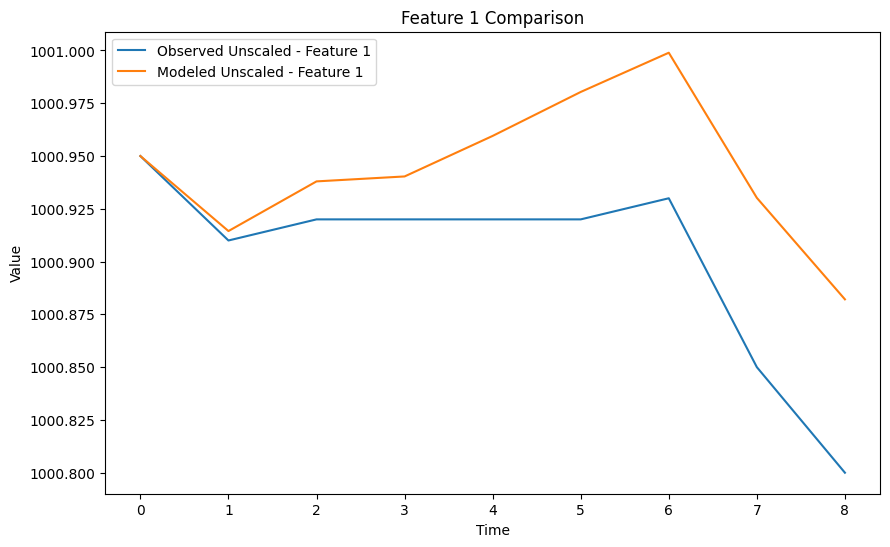

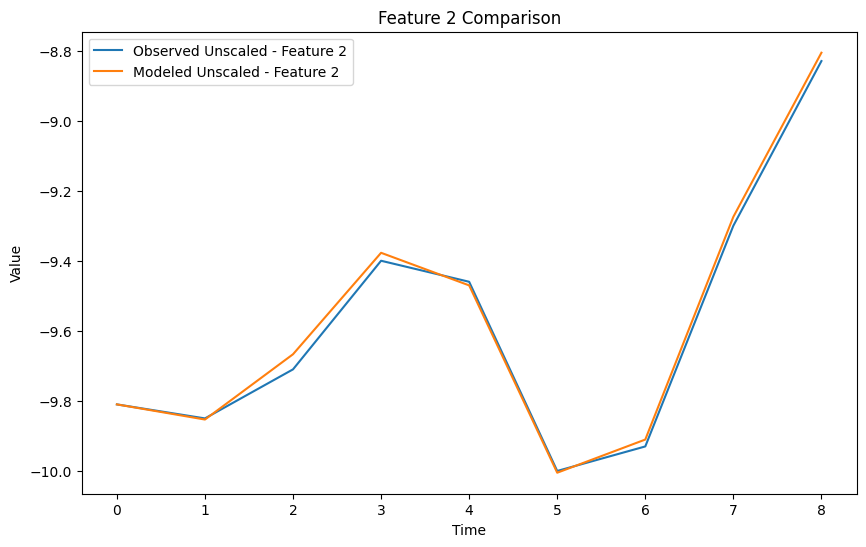

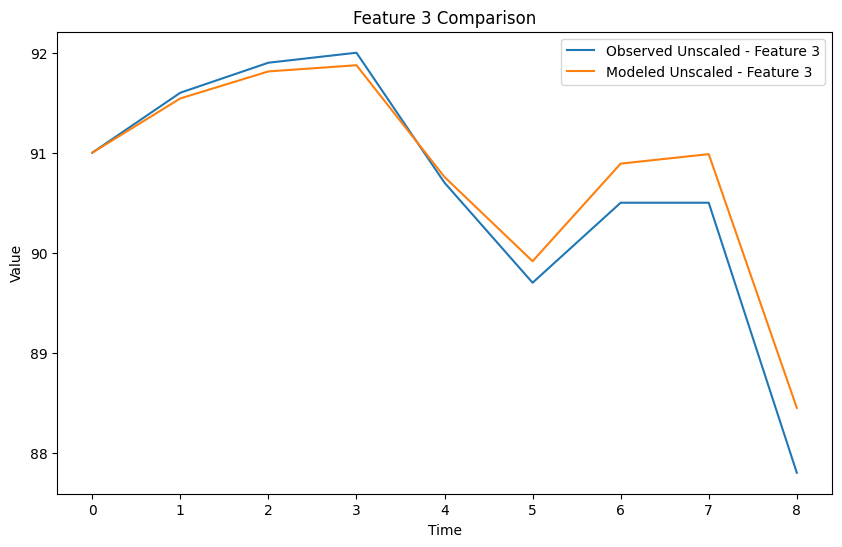

In [25]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)

In [26]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(cerberus_foresight)

18074371